# Part 1 (spectral unmixing)

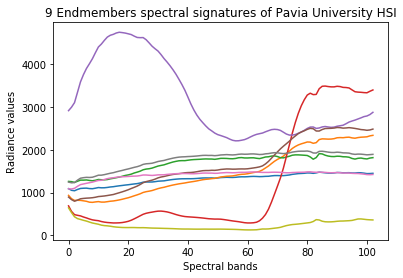

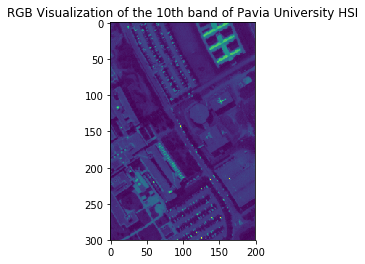

In [18]:
import scipy.io as sio
import numpy as np
import scipy.optimize 
import matplotlib.pyplot as plt
Pavia = sio.loadmat('PaviaU_cube.mat')
HSI = Pavia['X'] #Pavia HSI : 300x200x103

ends = sio.loadmat('PaviaU_endmembers.mat') # Endmember's matrix: 103x9
endmembers = ends['endmembers']
fig = plt.figure()
plt.plot(endmembers)
plt.ylabel('Radiance values')
plt.xlabel('Spectral bands')
plt.title('9 Endmembers spectral signatures of Pavia University HSI')
plt.show()

#Perform unmixing for the pixels corresponding to nonzero labels
ground_truth= sio.loadmat('PaviaU_ground_truth.mat')
labels=ground_truth['y']

fig = plt.figure()
plt.imshow(HSI[:,:,10])
plt.title('RGB Visualization of the 10th band of Pavia University HSI')
plt.show()
# For the non-negative least squares  unmixing algorithm  you can use the nnls function, see the following link:
#https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.optimize.nnls.html#scipy.optimize.nnls
# ..............
#
#..................

In [19]:
X = endmembers
Y = HSI
Xinv = np.linalg.inv(np.dot(X.T,X))
theta = np.zeros((300,200,9))
error = np.zeros((300,200))
for i in range(300):
    for j in range(200):
        if labels[i,j]!=0:
            theta[i,j] = (np.dot(Xinv,X.T).dot(Y[i,j])).T
            error[i,j] = np.power(np.linalg.norm(Y[i,j] - np.dot(X,theta[i,j])),2)
np.sum(error)/np.count_nonzero(error)

118783.18062626584

In [20]:
maps = np.zeros((300,200,9))
for i in range(300):
    for j in range(200):
        for m in range(9):
            maps[i,j,m] =  np.sum(np.dot(X[:,0].reshape(103,1),theta[i,j,m]))

Average Reconstruction Error :  118783.1806


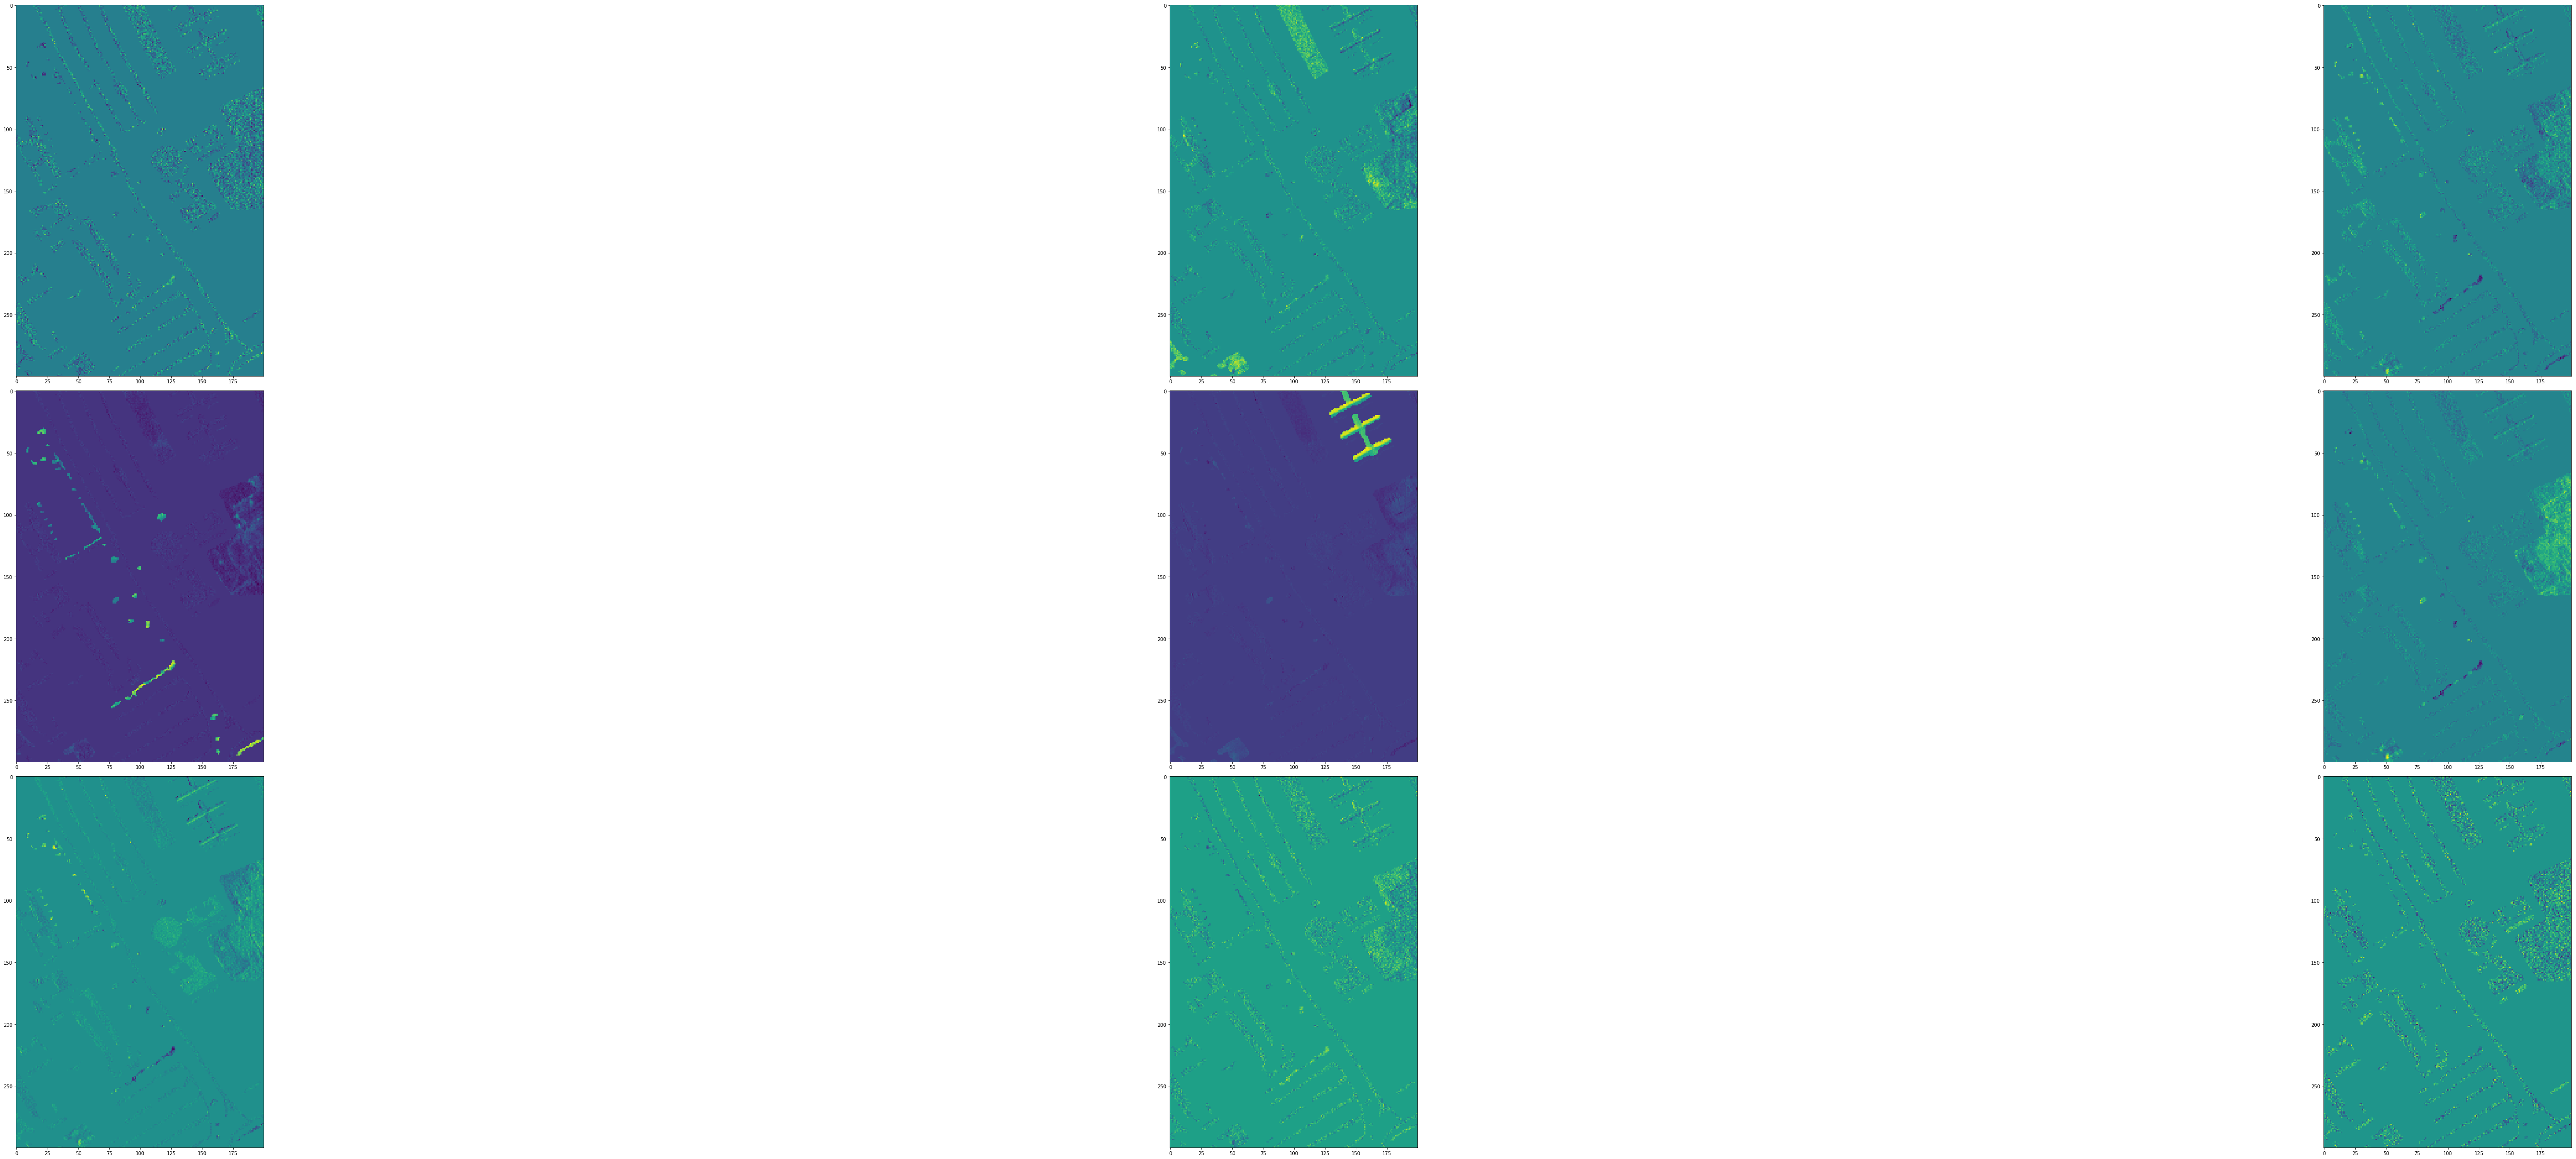

In [21]:
fig = plt.figure()
fig.set_figheight(100)
fig.set_figwidth(100)
for i in range(9):
    z = int(str(93) + str(i+1))
    plt.subplot(z)
    plt.imshow( maps[:,:,i] )
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0) 
print('Average Reconstruction Error : ', round(np.sum(error)/np.count_nonzero(error) ,4))     
plt.show()

# 1.b  sum-to-one constraint

 Least squares imposing the sum-to-one constraint

In [22]:
from scipy.optimize import minimize 
from scipy.optimize import nnls 

In [23]:
#Define minimisation function
def fn(x, A, b):
    return np.linalg.norm(A.dot(x) - b)

#Define constraints and bounds
cons = {'type': 'eq', 'fun': lambda x:  np.sum(x)-1}

theta_to_one = np.zeros((300,200,9))
rnorm = np.zeros((300,200))
error_to_one = np.zeros((300,200))
theta0 , rnorm = nnls(X,Y[0,0])
for i in range(300):
    for j in range(200):
        if labels[i,j]!=0:        
            minout = minimize(fn, theta0, args=(X,Y[i,j]), method='SLSQP',constraints=cons)
            theta_to_one[i,j] = minout.x
            error_to_one[i,j] = np.power(np.linalg.norm(Y[i,j] - np.dot(X,theta_to_one[i,j])),2)
np.sum(error_to_one)/np.count_nonzero(error_to_one)            

160049.93078254172

Average Reconstruction Error :  160049.9308


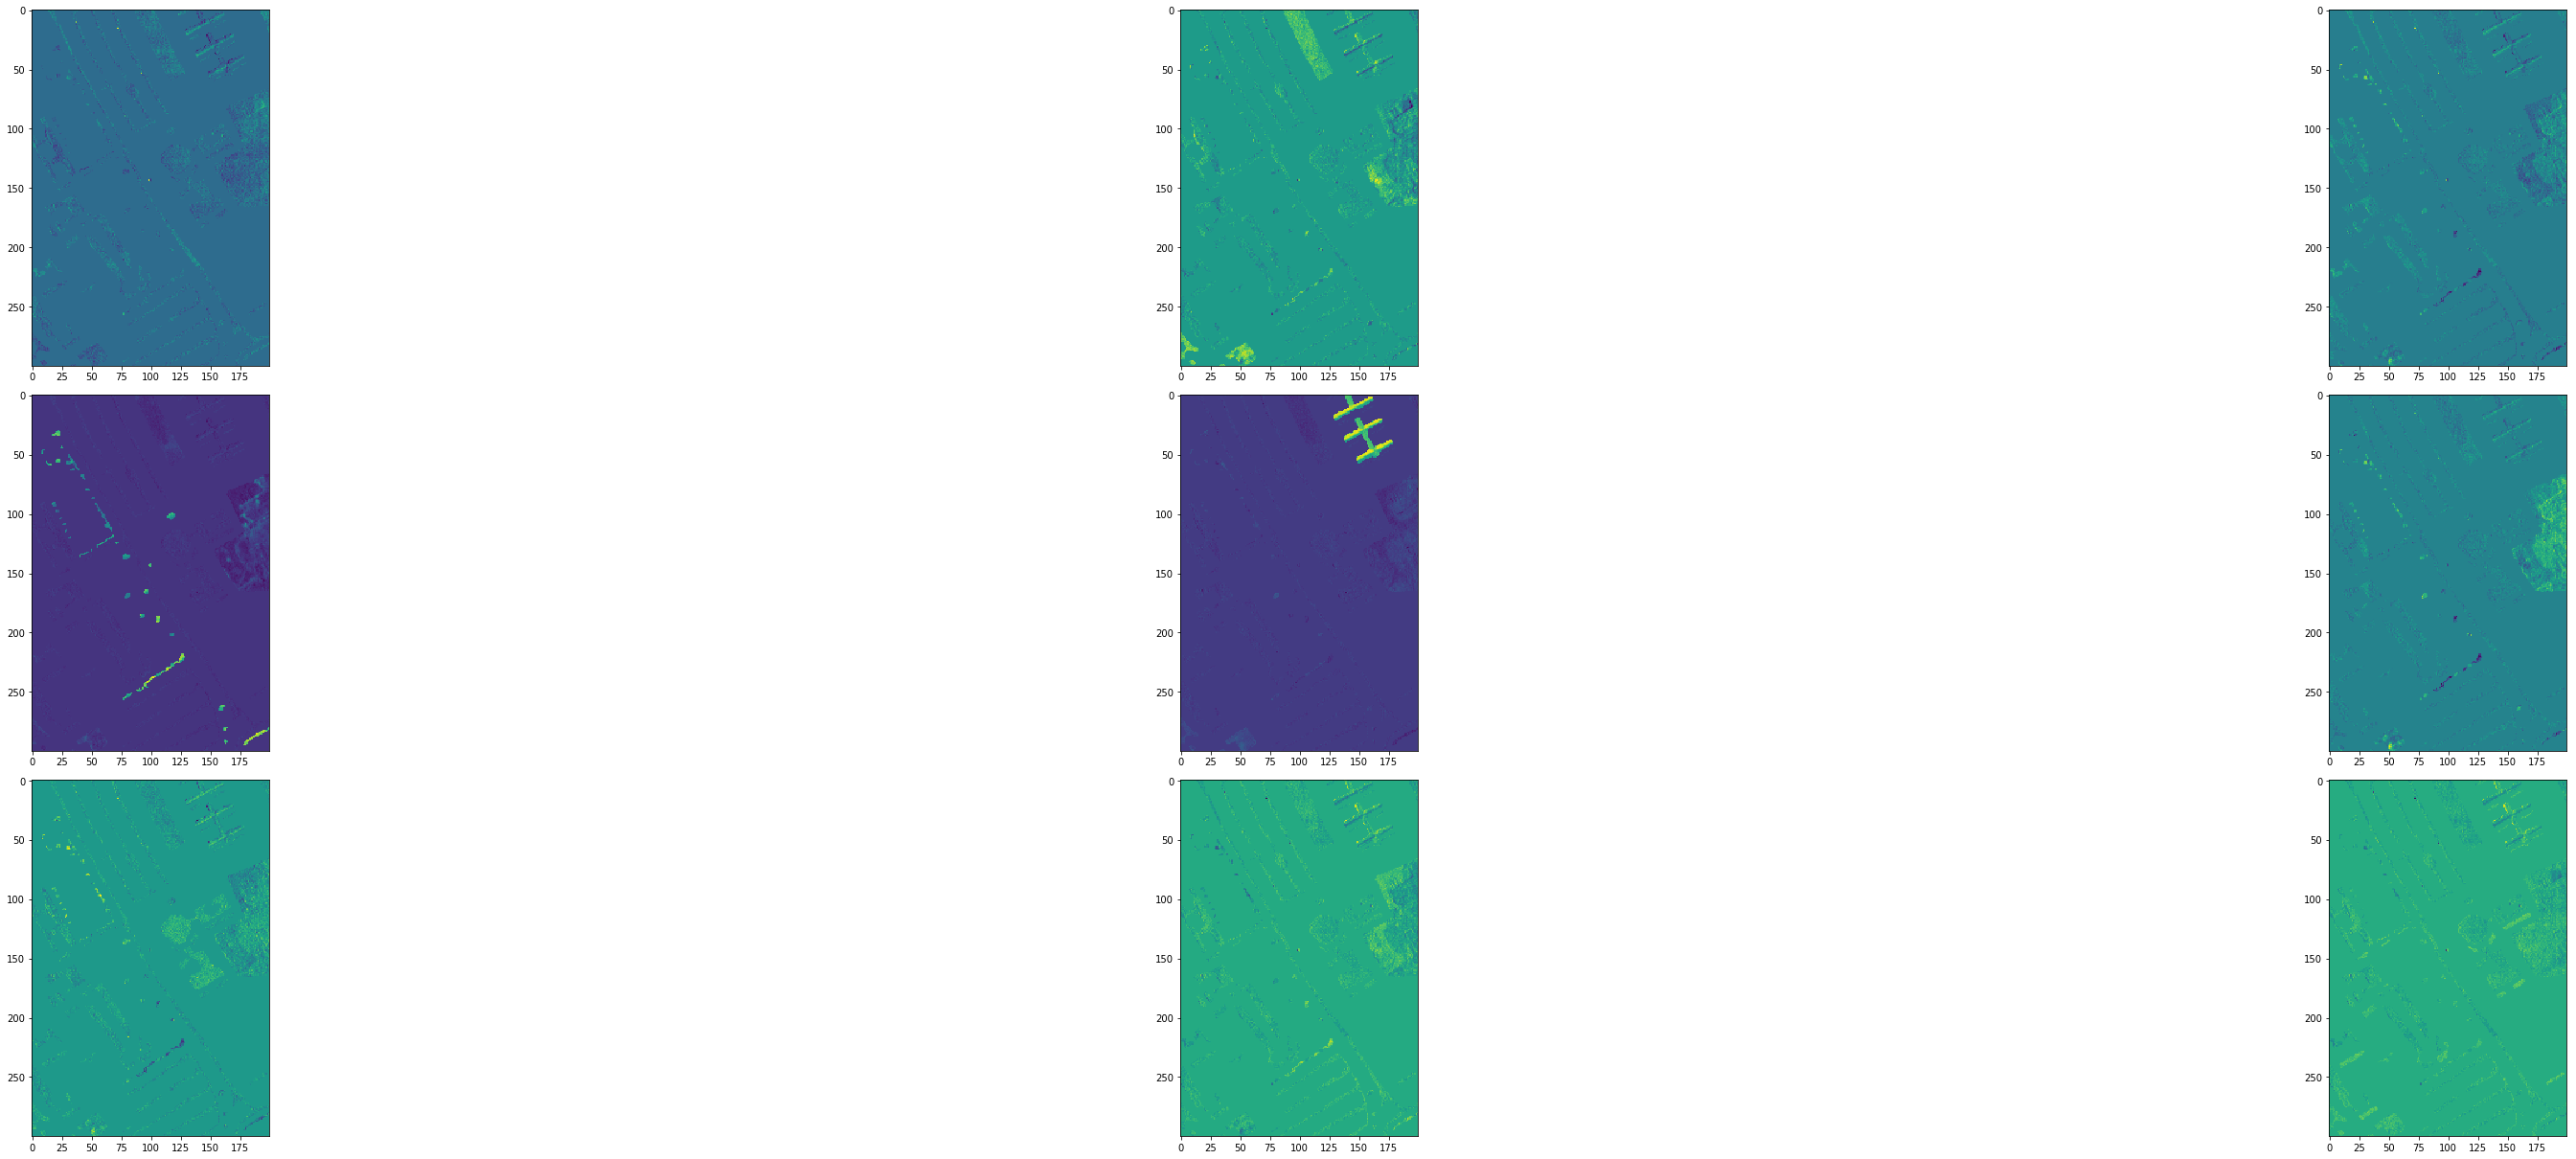

In [24]:
maps = np.zeros((300,200,9))
for i in range(300):
    for j in range(200):
        for m in range(9):
            maps[i,j,m] =  np.sum(np.dot(X[:,0].reshape(103,1),theta_to_one[i,j,m]))
fig = plt.figure()
fig.set_figheight(50)
fig.set_figwidth(50)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.2)
for i in range(9):
    z = int(str(93) + str(i+1))
    plt.subplot(z)
    plt.imshow( maps[:,:,i] )
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)  
print('Average Reconstruction Error : ', round(np.sum(error_to_one)/np.count_nonzero(error_to_one) ,4))     

# 1.c non-negativity constraint

Least squares imposing the non-negativity constraint on the entries of θ

In [25]:
bounds = [[0., None],[0., None],[0., None],[0., None],[0., None],[0., None],[0., None],[0., None],[0., None]]
theta_non_negative = np.zeros((300,200,9))
rnorm = np.zeros((300,200))
error_non_negative = np.zeros((300,200))
for i in range(300):
    for j in range(200):
        if labels[i,j]!=0:
            #Use nnls to get initial guess
            theta_non_negative[i,j] , rnorm[i,j] = nnls(X,Y[i,j])
            error_non_negative[i,j] = np.power(np.linalg.norm(Y[i,j] - np.dot(X,theta_non_negative[i,j])),2)
np.sum(error_non_negative)/np.count_nonzero(error_non_negative)             

569339.2910564167

Average Reconstruction Error :  569339.2911


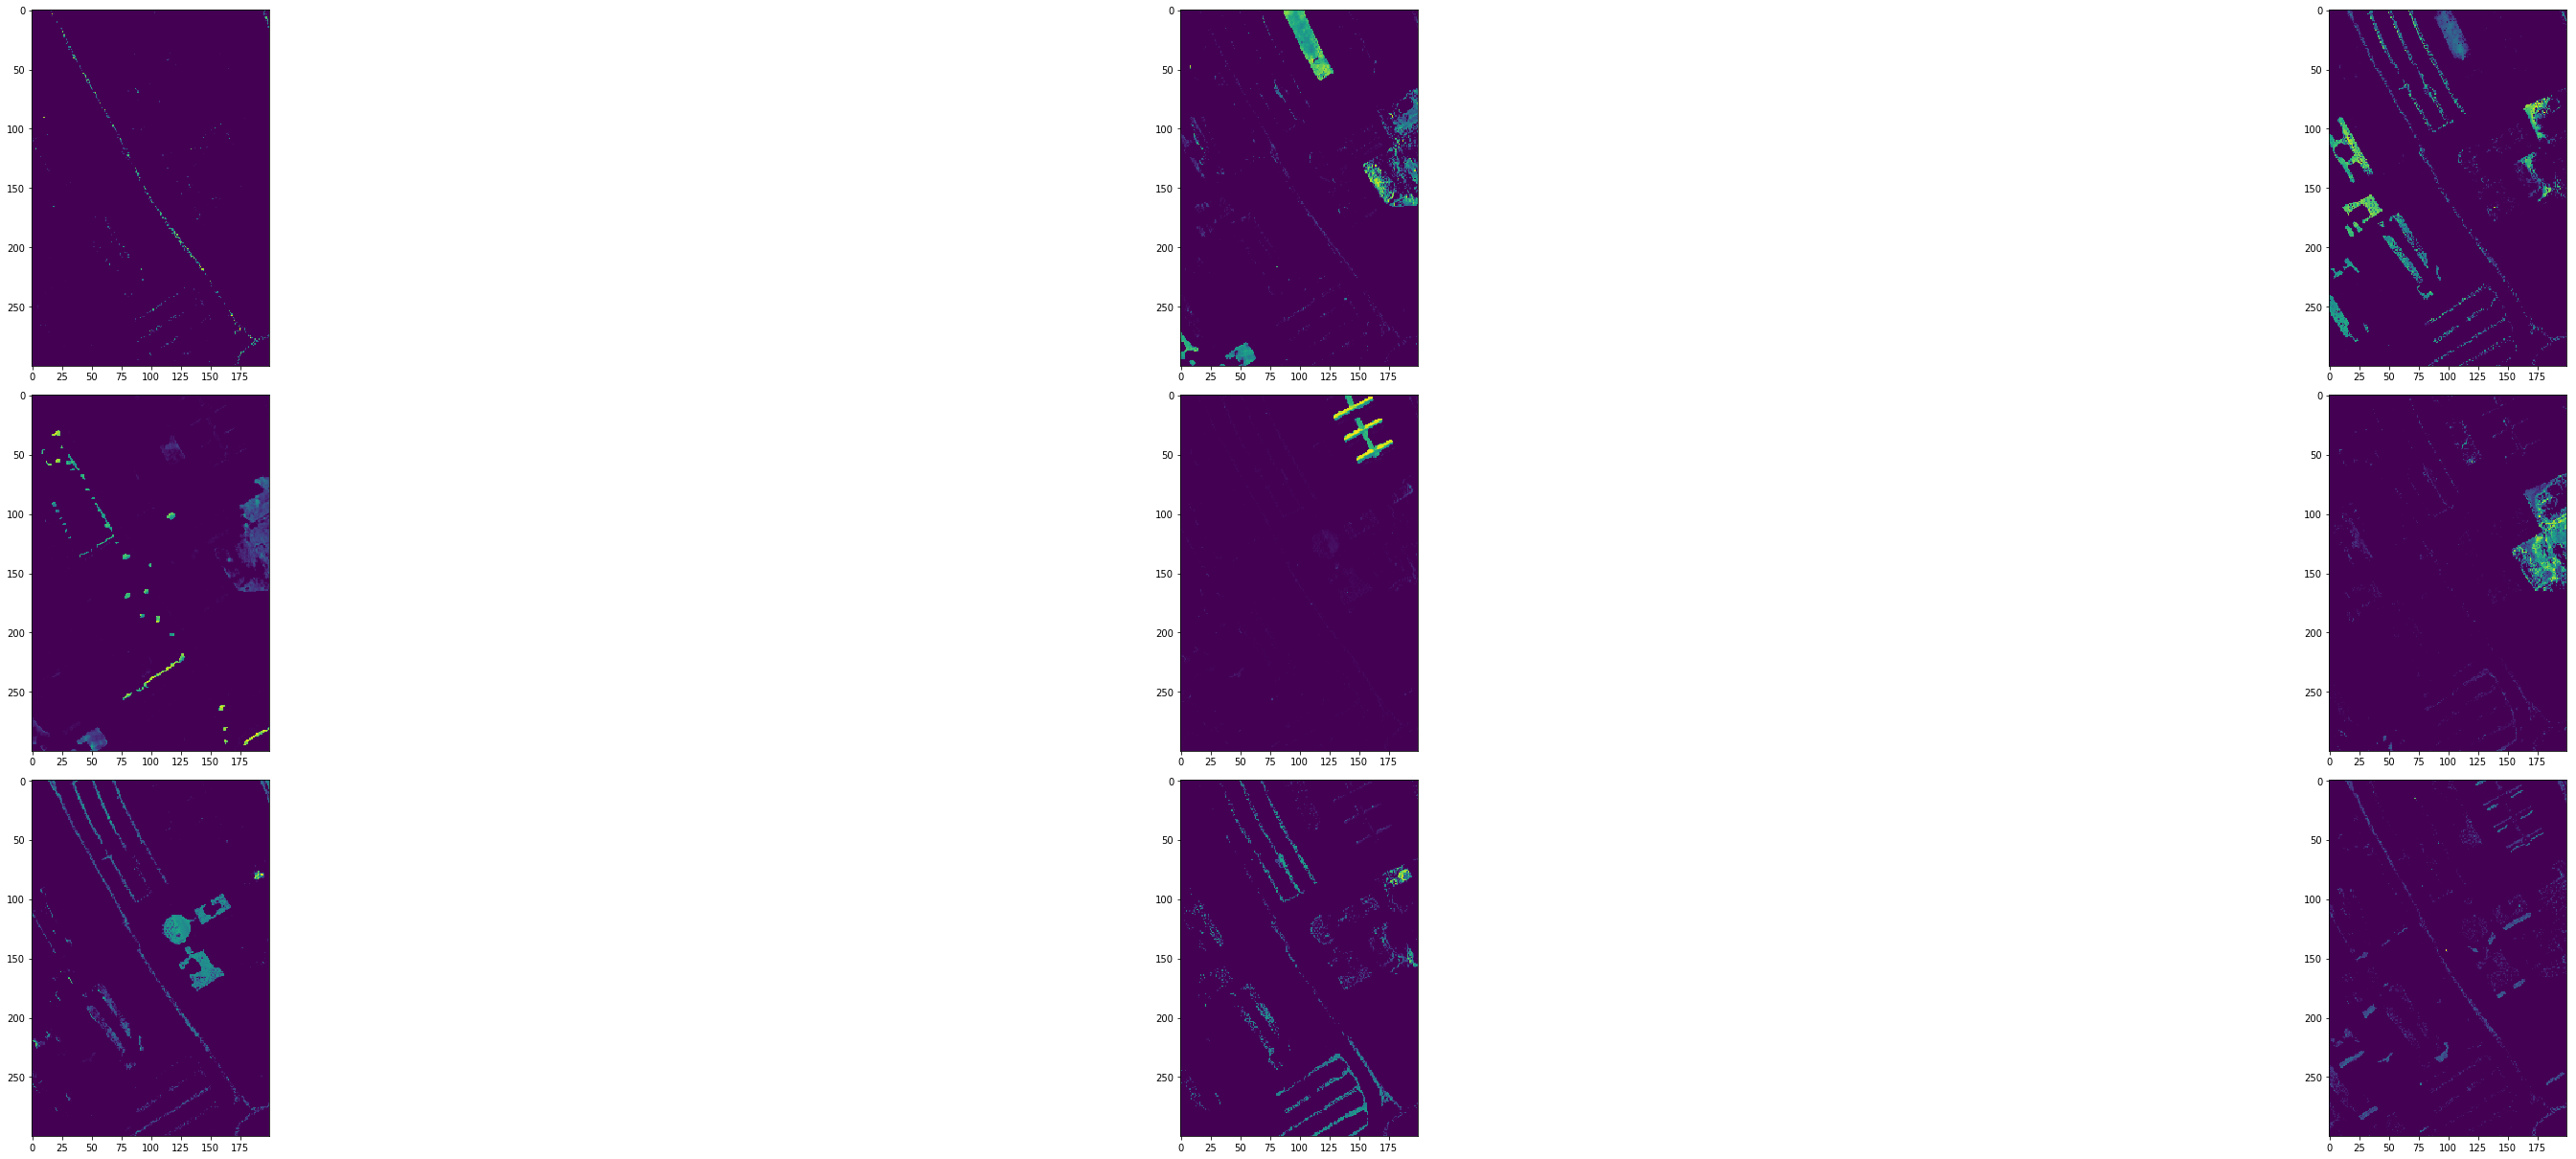

In [26]:
maps = np.zeros((300,200,9))
for i in range(300):
    for j in range(200):
        for m in range(9):
            maps[i,j,m] =  np.sum(np.dot(X[:,0].reshape(103,1),theta_non_negative[i,j,m]))
fig = plt.figure()
fig.set_figheight(50)
fig.set_figwidth(50)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.2)
for i in range(9):
    z = int(str(93) + str(i+1))
    plt.subplot(z)
    plt.imshow( maps[:,:,i] )
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
print('Average Reconstruction Error : ', round(np.sum(error_non_negative)/np.count_nonzero(error_non_negative) ,4)) 

# 1.d non-negativity and the sum-to-one constraint

Least squares imposing both the non-negativity and the sum-to-one constraint on the entries of θ.

In [27]:
#Define minimisation function
def fn(x, A, b):
    return np.linalg.norm(A.dot(x) - b)

#Define constraints and bounds
cons = {'type': 'eq', 'fun': lambda x:  np.sum(x)-1}
bounds = [[0., None],[0., None],[0., None],[0., None],[0., None],[0., None],[0., None],[0., None],[0., None]]

theta_pos_ones = np.zeros((300,200,9))
rnorm = np.zeros((300,200))
error_pos_ones= np.zeros((300,200))

for i in range(300):
    for j in range(200):
        if labels[i,j]!=0:
            #Use nnls to get initial guess
            theta_pos_ones[i,j] , rnorm[i,j] = nnls(X,Y[i,j])
            #Call minimisation subject to these values
            minout = minimize(fn, theta_pos_ones[i,j], args=(X,Y[i,j]), method='SLSQP',bounds=bounds,constraints=cons)
            theta_pos_ones[i,j] = minout.x
            error_pos_ones[i,j] = np.power(np.linalg.norm(Y[i,j] - np.dot(X,theta_pos_ones[i,j])),2)
np.sum(error_pos_ones)/np.count_nonzero(error_pos_ones)              

3165851.2764104973

In [28]:
np.mean(error_pos_ones)

676911.7670845045

Average Reconstruction Error :  3165851.2764


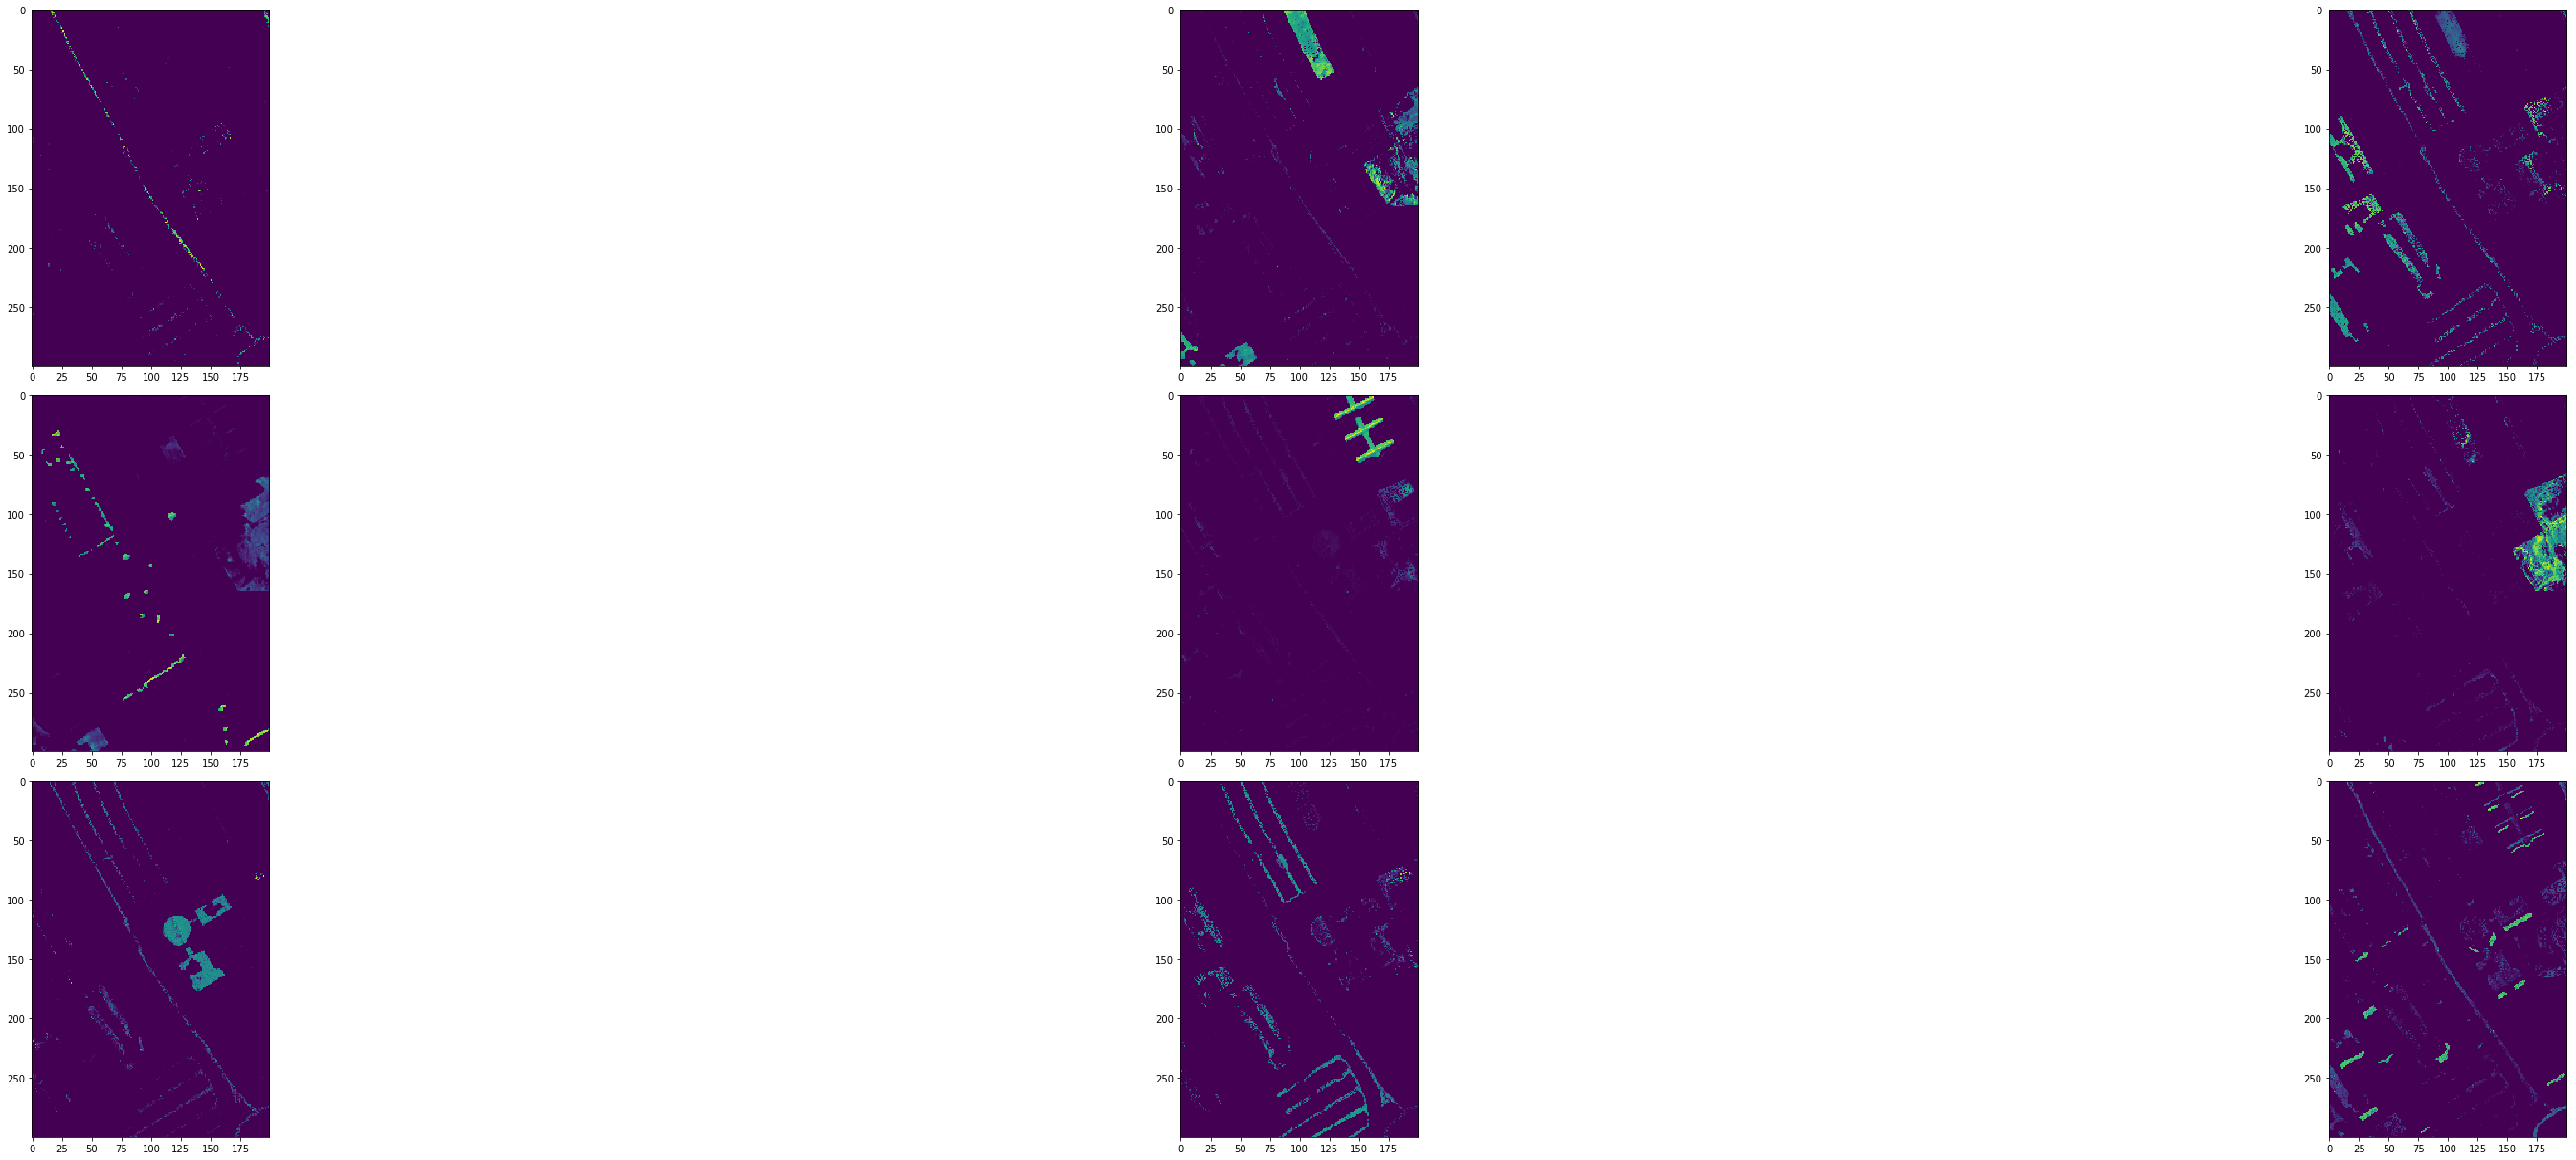

In [29]:
maps = np.zeros((300,200,9))
for i in range(300):
    for j in range(200):
        for m in range(9):
            maps[i,j,m] =  np.sum(np.dot(X[:,0].reshape(103,1),theta_pos_ones[i,j,m]))
fig = plt.figure()
fig.set_figheight(50)
fig.set_figwidth(50)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.2)
for i in range(9):
    z = int(str(93) + str(i+1))
    plt.subplot(z)
    plt.imshow( maps[:,:,i] )
    plt.tight_layout(pad=0.1, w_pad=0.1, h_pad=1.0)   
print('Average Reconstruction Error : ', round(np.sum(error_pos_ones)/np.count_nonzero(error_pos_ones) ,4))     

# 1.e LASSO

In [30]:
from sklearn.linear_model import Lasso

In [31]:
from sklearn import linear_model

In [32]:
clf = linear_model.Lasso(alpha=5, fit_intercept=False)

In [33]:
theta_lasso = np.zeros((300,200,9))
theta_lasso_est = np.zeros((300,200,10))
error_lasso = np.zeros((300,200))
for i in range(300):
    for j in range(200):
        if labels[i,j]!=0:
            clf.fit(X, Y[i,j])
            theta_lasso[i,j] = clf.coef_
            error_lasso[i,j] = np.power(np.linalg.norm(Y[i,j] - np.dot(X,theta_lasso[i,j])),2)
np.sum(error_lasso)/np.count_nonzero(error_lasso)  


C:\Users\p.rallis\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


206200.5138114169

Average Reconstruction Error :  206200.5138


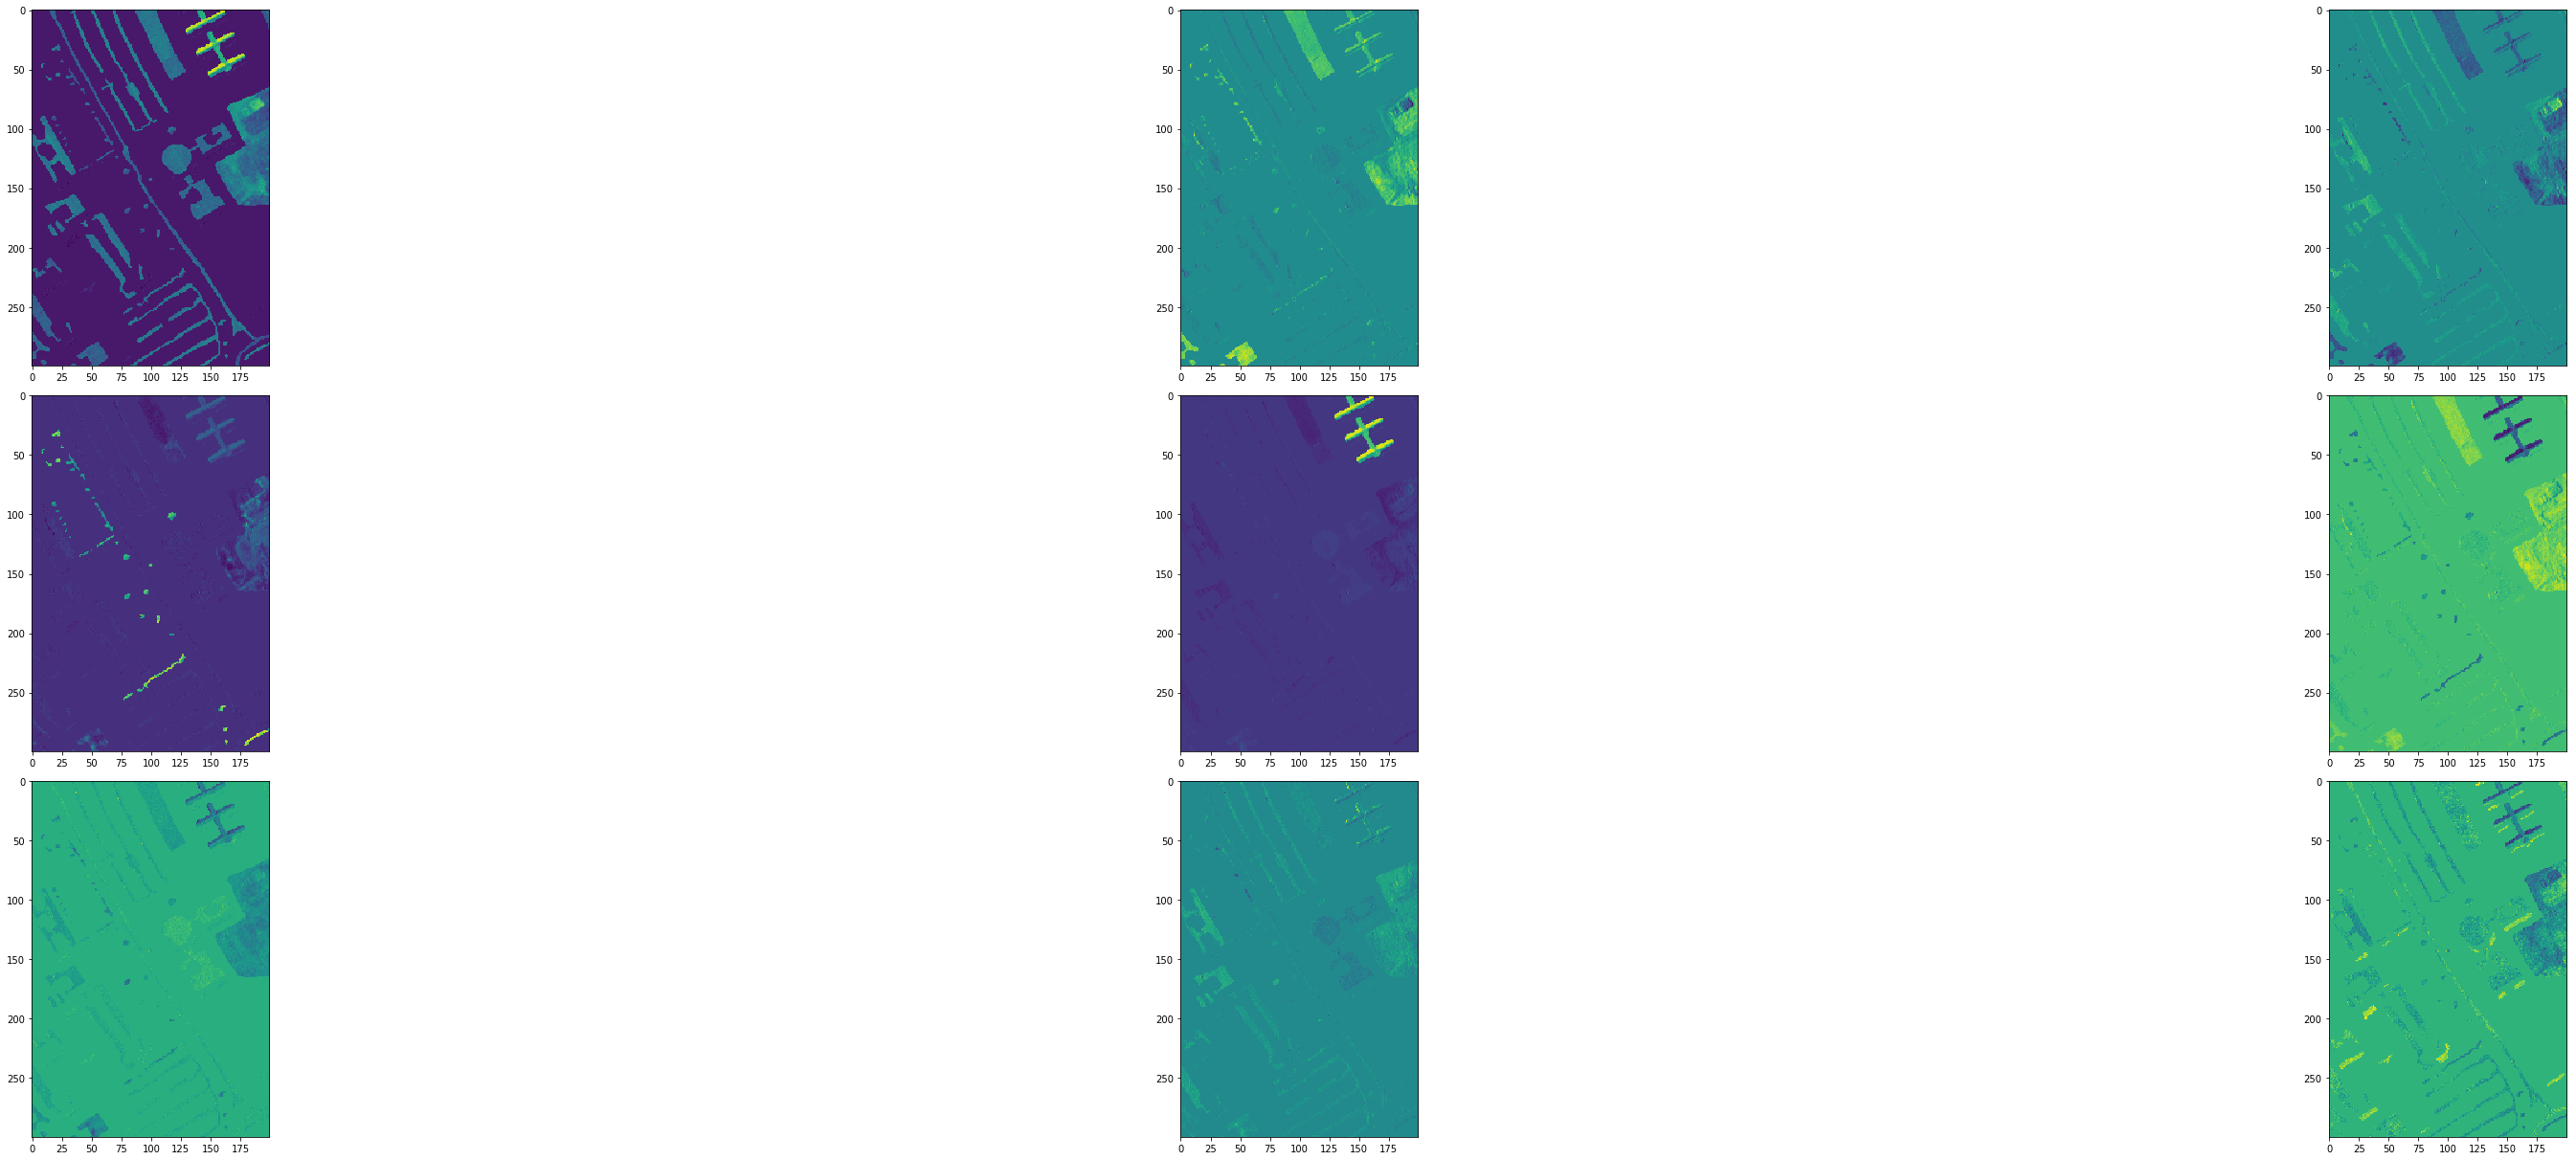

In [34]:
maps_lasso = np.zeros((300,200,9))
for i in range(300):
    for j in range(200):
        for m in range(9):
            maps_lasso[i,j,m] =  np.sum(np.dot(X[:,0].reshape(103,1),theta_lasso[i,j,m]))
fig = plt.figure()
fig.set_figheight(50)
fig.set_figwidth(50)
for i in range(9):
    z = int(str(93) + str(i+1))
    plt.subplot(z)
    plt.imshow( maps_lasso[:,:,i] )
    plt.tight_layout(pad=0.1, w_pad=0.1, h_pad=1.0)  
print('Average Reconstruction Error : ', round(np.sum(error_lasso)/np.count_nonzero(error_lasso) ,4))         
plt.show()

# Compare the results obtained from the above five methods

Comparing the average reconstruction error of each method, we have the below results:
* Unconstraint Least Squares : 118783.1806
* Sum to one                 : 160049.9308
* Lasso                      : 206200.5138
* Non negative               : 569339.2911
* Non negative and sum to one: 3237330.1318
<br> It is clear that reconstruction error is increased when imposing more constraints.
<br>However, focusing to abundance maps, it is clear that the reconstruction error is not related necessarly with the best unmixing result. As we know, the parameters(theta) of our models represent the proportion of each material in each pixel. It is obvious that each proportion has to be positive and summarise to one. Thus, the non negative and sum to one method is the most suitable for our problem, even though the reconstruction error is the highest. 
The above explanation is clear to the abundance maps where the non negative method and the non negative-sum to one method perform the best results.

# Part 2 (classification)

In [35]:
import pandas as pd

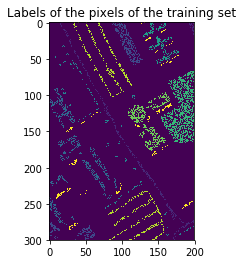

In [36]:
# Trainining set for classification 
Pavia_labels = sio.loadmat('classification_labels_Pavia.mat')
Training_Set = (np.reshape(Pavia_labels['training_set'],(200,300))).T
Test_Set = (np.reshape(Pavia_labels['test_set'],(200,300))).T
Operational_Set = (np.reshape(Pavia_labels['operational_set'],(200,300))).T

fig = plt.figure()
plt.imshow(Training_Set)
plt.title('Labels of the pixels of the training set')
plt.show()

In [37]:
#keep position(x,y) of non zero pixels
non_zero_Training_Set = np.argwhere(Training_Set)
#select pixels(vectors) according to non zero index
X_train = HSI[non_zero_Training_Set[:,0],non_zero_Training_Set[:,1]]
#select labels according to non zero index
y_train = Training_Set[non_zero_Training_Set[:,0],non_zero_Training_Set[:,1]]

non_zero_Test_Set = np.argwhere(Test_Set)
X_test = HSI[non_zero_Test_Set[:,0],non_zero_Test_Set[:,1]]
y_test = Test_Set[non_zero_Test_Set[:,0],non_zero_Test_Set[:,1]]

non_zero_Operational_Set = np.argwhere(Operational_Set)
y_true = Operational_Set[non_zero_Operational_Set[:,0],non_zero_Operational_Set[:,1]]

# The naive Bayes classifier

In [38]:
#Import Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB
#Create a Gaussian Classifier
clf_naive = GaussianNB()

In [39]:
# Train the model using the training sets
clf_naive.fit(X_train,y_train)

GaussianNB(priors=None)

In [40]:
#Predict Output using test set
y_pred_nb= clf_naive.predict(X_test)

In [41]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_nb))

Accuracy: 0.660118490801372


10-fold cross validation

In [42]:
#Split dataset into k consecutive folds (without shuffling by default).
from sklearn.model_selection import cross_val_score,KFold
cv = KFold(n_splits=10, shuffle=True, random_state=42)
scores_naive = cross_val_score(clf_naive, X_train, y_train, cv=cv, scoring='accuracy')
print(scores_naive)

[0.69470405 0.67912773 0.64641745 0.63551402 0.65420561 0.66146646
 0.6599064  0.67862715 0.63806552 0.65366615]


cross_val_score return a success score, so we have to find the error score

In [43]:
np.mean(1-scores_naive)

0.33982994833812047

In [44]:
np.std(1-scores_naive)

0.018049777399834096

Confusion Matrix

In [45]:
cm_naive=metrics.confusion_matrix(y_test, y_pred_nb, labels=None, sample_weight=None)

In [46]:
# cm2df: convert confusion matrix to dataframe with labels
import pandas as pd
import numpy as np

def cm2df(cm, labels):
    df = pd.DataFrame()
    # rows
    for i, row_label in enumerate(labels):
        rowdata={}
        # columns
        for j, col_label in enumerate(labels): 
            rowdata[col_label]=cm[i,j]
        df = df.append(pd.DataFrame.from_dict({row_label:rowdata}, orient='index'))
    return df[labels]

Success Rate : sum of the diagonal elements of the confusion matrix and divide by the sum of all elements of the matrix

In [47]:
success_rate_naive = np.sum(cm_naive.diagonal()) / np.sum(cm_naive)
success_rate_naive

0.660118490801372

In [48]:
print('********** Naive Bayes classifier ***********')
print('---------------------------------------------')
print('Success_Rate               : ', round(success_rate_naive,4))
print('Estimated Validation Error : ', round(np.mean(1-scores_naive),4))
print('Standard Deviation         : ', round(np.std(1-scores_naive),4))
print("\n                                Confusion Matrix")
print("----------------------------------------------------------------------------------------")
df = cm2df(cm_naive, ["Water", "Trees","Asphalt","Bricks","Bitumen","Tiles","Shadows","Meadows","Soil"])
print(df)

********** Naive Bayes classifier ***********
---------------------------------------------
Success_Rate               :  0.6601
Estimated Validation Error :  0.3398
Standard Deviation         :  0.018

                                Confusion Matrix
----------------------------------------------------------------------------------------
         Water  Trees  Asphalt  Bricks  Bitumen  Tiles  Shadows  Meadows  Soil
Water      131      0       37       0        0      0       80       13     0
Trees        0    326        4       6        0     17        0        0     0
Asphalt     25      2      127       0        0     13       70      299     0
Bricks       0      0        0     154        1      1        0        0     0
Bitumen      0      0        1       0      166      1        0        0     0
Tiles        0    312        2      55       32    363        0        0     0
Shadows     18      0       26       0        0      0      277        0     0
Meadows      2      1      

# The k-nearest neighbor classifier

In [49]:
from sklearn.neighbors import KNeighborsClassifier

In [50]:
clf_knn = KNeighborsClassifier(n_neighbors=9)

In [51]:
clf_knn.fit(X_train, y_train) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=9, p=2,
           weights='uniform')

In [52]:
y_pred_knn= clf_knn.predict(X_test)

In [53]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_knn))

Accuracy: 0.8802619270346118


10-fold cross validation

In [54]:
#Split dataset into k consecutive folds (without shuffling by default).
from sklearn.model_selection import cross_val_score,KFold
cv = KFold(n_splits=10, shuffle=True, random_state=42)
scores_knn = cross_val_score(clf_knn, X_train, y_train, cv=cv, scoring='accuracy')
print(scores_knn)

[0.88629283 0.894081   0.894081   0.87694704 0.86137072 0.85335413
 0.88455538 0.90483619 0.87363495 0.87207488]


In [55]:
np.mean(1-scores_knn)

0.11987718761086892

In [56]:
np.std(1-scores_knn)

0.014977584022503761

Confusion Matrix

In [57]:
cm_knn=metrics.confusion_matrix(y_test, y_pred_knn, labels=None, sample_weight=None)

Success Rate

In [58]:
success_rate_knn = np.sum(cm_knn.diagonal()) / np.sum(cm_knn)
success_rate_knn

0.8802619270346118

In [59]:
print('******* k-nearest neighbor classifier *******')
print('---------------------------------------------')
print('Success_Rate               : ', round(success_rate_knn,4))
print('Estimated Validation Error : ', round(np.mean(1-scores_knn),4))
print('Standard Deviation         : ', round(np.std(1-scores_knn),4))
print("\n                                Confusion Matrix")
print("----------------------------------------------------------------------------------------")
df = cm2df(cm_knn, ["Water", "Trees","Asphalt","Bricks","Bitumen","Tiles","Shadows","Meadows","Soil"])
print(df)

******* k-nearest neighbor classifier *******
---------------------------------------------
Success_Rate               :  0.8803
Estimated Validation Error :  0.1199
Standard Deviation         :  0.015

                                Confusion Matrix
----------------------------------------------------------------------------------------
         Water  Trees  Asphalt  Bricks  Bitumen  Tiles  Shadows  Meadows  Soil
Water      188      0       13       0        0      0       28       32     0
Trees        0    323        0       1        0     28        0        1     0
Asphalt     11      2      446       0        0      5        1       71     0
Bricks       0      0        0     155        0      1        0        0     0
Bitumen      0      0        1       0      166      0        0        1     0
Tiles        0     63        1       0        1    697        0        2     0
Shadows     13      0        5       0        0      0      301        2     0
Meadows      9      2      

# The minimum Euclidean distance classifier

In [60]:
kf = KFold(10)
scores_ed = []

In [61]:
for train_index, test_index in kf.split(X_train):
        cur_x_train = X_train[train_index]
        cur_y_train = y_train[train_index]

        cur_x_test  = X_train[test_index]
        cur_y_test  = y_train[test_index]

        mean1 = np.mean(cur_x_train[cur_y_train==1], axis = 0)
        mean2 = np.mean(cur_x_train[cur_y_train==2], axis = 0)
        mean3 = np.mean(cur_x_train[cur_y_train==3], axis = 0)
        mean4 = np.mean(cur_x_train[cur_y_train==4], axis = 0)
        mean5 = np.mean(cur_x_train[cur_y_train==5], axis = 0)
        mean6 = np.mean(cur_x_train[cur_y_train==6], axis = 0)
        mean7 = np.mean(cur_x_train[cur_y_train==7], axis = 0)
        mean8 = np.mean(cur_x_train[cur_y_train==8], axis = 0)
        mean9 = np.mean(cur_x_train[cur_y_train==9], axis = 0)
        
        mean = np.vstack((mean1, mean2, mean3, mean4, mean5, mean6, mean7, mean8, mean9))  
        dist = np.empty((len(mean)))          
        classes = np.array([1,2,3,4,5,6,7,8,9])
        new_class = np.empty((len(cur_y_test)))
        
        for i in range(cur_x_test.shape[0]):
            for j in range(len(classes)):                                    
                    dist[j] = (np.linalg.norm((cur_x_test[i,:]) - mean[j]))  
            new_class[i] = np.dot((dist.min() == dist), classes)  
        
        cnt = 0
        for i in range(len(cur_y_test)):
            if new_class[i] == cur_y_test[i]:   
                cnt = cnt + 1
        scores_ed.append(cnt / len(cur_y_test))

In [62]:
scores_ed

[0.5950155763239875,
 0.7601246105919003,
 0.4392523364485981,
 0.5327102803738317,
 0.46105919003115264,
 0.5351014040561622,
 0.41809672386895474,
 0.6287051482059283,
 0.40093603744149764,
 0.5756630265210608]

In [63]:
#Calculate Validation Error & Standard deviation
error_ed = []
for i in range(10):
    error_ed.append(round(1 - scores_ed[i] ,6))   

In [64]:
np.mean(error_ed) 

0.4653336

In [65]:
np.std(error_ed)   

0.10535456913508784

In [66]:
ms=[]
for i in range(1, 10):
    a = np.mean( HSI[Training_Set==i], axis = 0)
    #a = np.mean(X_train[y_train==i], axis = 0)
    ms.append(a)

m = np.vstack(ms)

dist      = np.empty((len(mean)))         
classes   = np.array([1,2,3,4,5,6,7,8,9])       
y_pred_ed = np.empty(X_test.shape[0])
for i in range(X_test.shape[0]): 
    for j in range(len(classes)):                                    
        dist[j] = (np.linalg.norm(X_test[i,:] - m[j]))  
    y_pred_ed[i] = np.dot((dist.min() == dist), classes)    


In [67]:
cm_ed = metrics.confusion_matrix(y_test, y_pred_ed)

In [68]:
success_rate_ed = np.diag(cm_ed).sum() / cm_ed.sum()

In [69]:
print('**** Minimum Euclidean Distance Classifier ****')
print('-----------------------------------------------')
print('Success_Rate               : ', round(success_rate_ed,4))
print('Estimated Validation Error : ', round(np.mean(error_ed),4))
print('Standard Deviation         : ', round(np.std(error_ed),4))
print("\n                                Confusion Matrix")
print("----------------------------------------------------------------------------------------")
df = cm2df(cm_ed, ["Water", "Trees","Asphalt","Bricks","Bitumen","Tiles","Shadows","Meadows","Soil"])
print(df)

**** Minimum Euclidean Distance Classifier ****
-----------------------------------------------
Success_Rate               :  0.5578
Estimated Validation Error :  0.4653
Standard Deviation         :  0.1054

                                Confusion Matrix
----------------------------------------------------------------------------------------
         Water  Trees  Asphalt  Bricks  Bitumen  Tiles  Shadows  Meadows  Soil
Water      152      0       46       0        0      0       61        2     0
Trees        1    188        0       5        0    156        0        3     0
Asphalt     66      2      198       0        0      1       39      230     0
Bricks       0      0        0     154        0      0        0        0     2
Bitumen      0      0        0       0      128      0        0       40     0
Tiles       11    317        0      12       16    240        0      168     0
Shadows     61      0       23       0        0      0      237        0     0
Meadows      2      1 

# Bayesian classifier

* Manual Bayes implementation

In [70]:
N = len(X_train)
N1 = np.count_nonzero(y_train==1)
N2 = np.count_nonzero(y_train==2)
N3 = np.count_nonzero(y_train==3)
N4 = np.count_nonzero(y_train==4)
N5 = np.count_nonzero(y_train==5)
N6 = np.count_nonzero(y_train==6)
N7 = np.count_nonzero(y_train==7)
N8 = np.count_nonzero(y_train==8)
N9 = np.count_nonzero(y_train==9)
P1 = N1/N
P2 = N2/N
P3 = N3/N
P4 = N4/N
P5 = N5/N
P6 = N6/N
P7 = N7/N
P8 = N8/N
P9 = N9/N
P1,P2,P3,P4,P5,P6,P7,P8,P9

(0.08963367108339829,
 0.1088074824629774,
 0.1579111457521434,
 0.04614185502727981,
 0.055962587685113016,
 0.23569758378799688,
 0.10568978955572876,
 0.13858144972720188,
 0.06157443491816056)

In [71]:
index1 =  (y_train==1).reshape(len(y_train))
index2 =  (y_train==2).reshape(len(y_train))
index3 =  (y_train==3).reshape(len(y_train))
index4 =  (y_train==4).reshape(len(y_train))
index5 =  (y_train==5).reshape(len(y_train))
index6 =  (y_train==6).reshape(len(y_train))
index7 =  (y_train==7).reshape(len(y_train))
index8 =  (y_train==8).reshape(len(y_train))
index9 =  (y_train==9).reshape(len(y_train))

class1 = X_train[index1,:]
class2 = X_train[index2,:]
class3 = X_train[index3,:]
class4 = X_train[index4,:]
class5 = X_train[index5,:]
class6 = X_train[index6,:]
class7 = X_train[index7,:]
class8 = X_train[index8,:]
class9 = X_train[index9,:]


In [72]:
mean_c1 = np.mean(class1,0)
mean_c2 = np.mean(class2,0)
mean_c3 = np.mean(class3,0)
mean_c4 = np.mean(class4,0)
mean_c5 = np.mean(class5,0)
mean_c6 = np.mean(class6,0)
mean_c7 = np.mean(class7,0)
mean_c8 = np.mean(class8,0)
mean_c9 = np.mean(class9,0)

In [73]:
distance1=class1- mean_c1
distance2=class2- mean_c2
distance3=class3- mean_c3
distance4=class4- mean_c4
distance5=class5- mean_c5
distance6=class6- mean_c6
distance7=class7- mean_c7
distance8=class8- mean_c8
distance9=class9- mean_c9


In [74]:
S1 = 1/N1*((class1 - np.matlib.repmat(mean_c1,N1,1)).T).dot((class1 - np.matlib.repmat(mean_c1,N1,1)))
S2 = 1/N2*((class2 - np.matlib.repmat(mean_c2,N2,1)).T).dot((class2 - np.matlib.repmat(mean_c2,N2,1)))
S3 = 1/N3*((class3 - np.matlib.repmat(mean_c3,N3,1)).T).dot((class3 - np.matlib.repmat(mean_c3,N3,1)))
S4 = 1/N4*((class4 - np.matlib.repmat(mean_c4,N4,1)).T).dot((class4 - np.matlib.repmat(mean_c4,N4,1)))
S5 = 1/N5*((class5 - np.matlib.repmat(mean_c5,N5,1)).T).dot((class5 - np.matlib.repmat(mean_c5,N5,1)))
S6 = 1/N6*((class6 - np.matlib.repmat(mean_c6,N6,1)).T).dot((class6 - np.matlib.repmat(mean_c6,N6,1)))
S7 = 1/N7*((class7 - np.matlib.repmat(mean_c7,N7,1)).T).dot((class7 - np.matlib.repmat(mean_c7,N7,1)))
S8 = 1/N8*((class8 - np.matlib.repmat(mean_c8,N8,1)).T).dot((class8 - np.matlib.repmat(mean_c8,N8,1)))
S9 = 1/N9*((class9 - np.matlib.repmat(mean_c9,N9,1)).T).dot((class9 - np.matlib.repmat(mean_c9,N9,1)))


In [75]:
from scipy.stats import multivariate_normal
from math import exp
y_predict_bayes_full=[]
for i in range(len(X_test)):
    # P(ω_j)*p(x|ω_j) for each x
    a=[P1*multivariate_normal.pdf(X_test[i], mean_c1,S1),
       P2*multivariate_normal.pdf(X_test[i], mean_c2,S2),
       P3*multivariate_normal.pdf(X_test[i], mean_c3,S3),
       P4*multivariate_normal.pdf(X_test[i], mean_c4,S4),
       P5*multivariate_normal.pdf(X_test[i], mean_c5,S5),
       P6*multivariate_normal.pdf(X_test[i], mean_c6,S6),
       P7*multivariate_normal.pdf(X_test[i], mean_c7,S7),
       P8*multivariate_normal.pdf(X_test[i], mean_c8,S8),
       P9*multivariate_normal.pdf(X_test[i], mean_c9,S9)]
    y_predict_bayes_full.append(a.index(max(a)))

y_predict_bayes_full=np.array(y_predict_bayes_full)+1
y_predict_bayes_full


array([1, 1, 8, ..., 2, 8, 8])

In [76]:
counter = 0
for i in range(len(X_test)):
    if y_test[i]!= y_predict_bayes_full[i]:
        counter += 1

parametric_error=counter/len(y_test)
parametric_error

0.11568444028687247

11.56% of points were classified in wrong class, which is a low proportion of error.

In [77]:
scores_bayes = []
kf = KFold(n_splits=10, shuffle=True, random_state=42)
for train_index, test_index in kf.split(X_train):
    cur_x_train = X_train[train_index]
    cur_y_train = y_train[train_index]
    cur_x_test  = X_train[test_index]
    cur_y_test  = y_train[test_index]
    
    N = len(cur_x_train)
    N1 = np.count_nonzero(cur_y_train==1)
    N2 = np.count_nonzero(cur_y_train==2)
    N3 = np.count_nonzero(cur_y_train==3)
    N4 = np.count_nonzero(cur_y_train==4)
    N5 = np.count_nonzero(cur_y_train==5)
    N6 = np.count_nonzero(cur_y_train==6)
    N7 = np.count_nonzero(cur_y_train==7)
    N8 = np.count_nonzero(cur_y_train==8)
    N9 = np.count_nonzero(cur_y_train==9)
    P1 = N1/N
    P2 = N2/N
    P3 = N3/N
    P4 = N4/N
    P5 = N5/N
    P6 = N6/N
    P7 = N7/N
    P8 = N8/N
    P9 = N9/N
    P1,P2,P3,P4,P5,P6,P7,P8,P9
    index1 =  (cur_y_train==1).reshape(len(cur_y_train))
    index2 =  (cur_y_train==2).reshape(len(cur_y_train))
    index3 =  (cur_y_train==3).reshape(len(cur_y_train))
    index4 =  (cur_y_train==4).reshape(len(cur_y_train))
    index5 =  (cur_y_train==5).reshape(len(cur_y_train))
    index6 =  (cur_y_train==6).reshape(len(cur_y_train))
    index7 =  (cur_y_train==7).reshape(len(cur_y_train))
    index8 =  (cur_y_train==8).reshape(len(cur_y_train))
    index9 =  (cur_y_train==9).reshape(len(cur_y_train))
    class1 = cur_x_train[index1,:]
    class2 = cur_x_train[index2,:]
    class3 = cur_x_train[index3,:]
    class4 = cur_x_train[index4,:]
    class5 = cur_x_train[index5,:]
    class6 = cur_x_train[index6,:]
    class7 = cur_x_train[index7,:]
    class8 = cur_x_train[index8,:]
    class9 = cur_x_train[index9,:]
    mean_c1 = np.mean(class1,0)
    mean_c2 = np.mean(class2,0)
    mean_c3 = np.mean(class3,0)
    mean_c4 = np.mean(class4,0)
    mean_c5 = np.mean(class5,0)
    mean_c6 = np.mean(class6,0)
    mean_c7 = np.mean(class7,0)
    mean_c8 = np.mean(class8,0)
    mean_c9 = np.mean(class9,0)
    distance1=class1- mean_c1
    distance2=class2- mean_c2
    distance3=class3- mean_c3
    distance4=class4- mean_c4
    distance5=class5- mean_c5
    distance6=class6- mean_c6
    distance7=class7- mean_c7
    distance8=class8- mean_c8
    distance9=class9- mean_c9
    S1 = 1/N1*((class1 - np.matlib.repmat(mean_c1,N1,1)).T).dot((class1 - np.matlib.repmat(mean_c1,N1,1)))
    S2 = 1/N2*((class2 - np.matlib.repmat(mean_c2,N2,1)).T).dot((class2 - np.matlib.repmat(mean_c2,N2,1)))
    S3 = 1/N3*((class3 - np.matlib.repmat(mean_c3,N3,1)).T).dot((class3 - np.matlib.repmat(mean_c3,N3,1)))
    S4 = 1/N4*((class4 - np.matlib.repmat(mean_c4,N4,1)).T).dot((class4 - np.matlib.repmat(mean_c4,N4,1)))
    S5 = 1/N5*((class5 - np.matlib.repmat(mean_c5,N5,1)).T).dot((class5 - np.matlib.repmat(mean_c5,N5,1)))
    S6 = 1/N6*((class6 - np.matlib.repmat(mean_c6,N6,1)).T).dot((class6 - np.matlib.repmat(mean_c6,N6,1)))
    S7 = 1/N7*((class7 - np.matlib.repmat(mean_c7,N7,1)).T).dot((class7 - np.matlib.repmat(mean_c7,N7,1)))
    S8 = 1/N8*((class8 - np.matlib.repmat(mean_c8,N8,1)).T).dot((class8 - np.matlib.repmat(mean_c8,N8,1)))
    S9 = 1/N9*((class9 - np.matlib.repmat(mean_c9,N9,1)).T).dot((class9 - np.matlib.repmat(mean_c9,N9,1)))
    from scipy.stats import multivariate_normal
    from math import exp
    y_predict_bayes_fold=[]
    for i in range(len(cur_x_test)):
        # P(ω_j)*p(x|ω_j) for each x
        a=[P1*multivariate_normal.pdf(cur_x_test[i], mean_c1,S1),
           P2*multivariate_normal.pdf(cur_x_test[i], mean_c2,S2),
           P3*multivariate_normal.pdf(cur_x_test[i], mean_c3,S3),
           P4*multivariate_normal.pdf(cur_x_test[i], mean_c4,S4),
           P5*multivariate_normal.pdf(cur_x_test[i], mean_c5,S5),
           P6*multivariate_normal.pdf(cur_x_test[i], mean_c6,S6),
           P7*multivariate_normal.pdf(cur_x_test[i], mean_c7,S7),
           P8*multivariate_normal.pdf(cur_x_test[i], mean_c8,S8),
           P9*multivariate_normal.pdf(cur_x_test[i], mean_c9,S9)]
        y_predict_bayes_fold.append(a.index(max(a)))
    y_predict_bayes_fold=np.array(y_predict_bayes_fold)+1 
    cnt = 0
    for i in range(len(cur_y_test)):    
        if y_predict_bayes_fold[i] == cur_y_test[i]:   
            cnt = cnt + 1
    scores_bayes.append(cnt / len(cur_y_test))

In [78]:
scores_bayes

[0.881619937694704,
 0.867601246105919,
 0.8925233644859814,
 0.8738317757009346,
 0.8722741433021807,
 0.8845553822152886,
 0.8876755070202809,
 0.8970358814352574,
 0.8767550702028081,
 0.8627145085803433]

In [79]:
np.mean(scores_bayes)

0.8796586816743698

In [80]:
error_bayes = []
for i in range(10):
    error_bayes.append(round(1 - scores_bayes[i] ,6))  

In [81]:
np.mean(error_bayes)

0.12034129999999998

In [82]:
np.std(error_bayes)

0.010435282076206658

In [83]:
cm_bayes=metrics.confusion_matrix(y_test, y_predict_bayes_full, labels=None, sample_weight=None)
cm_bayes

array([[155,   0,  46,   0,   0,   2,  10,  48,   0],
       [  0, 328,   0,   3,   0,  22,   0,   0,   0],
       [ 10,   1, 430,   0,   0,   0,   0,  95,   0],
       [  0,   0,   0, 154,   0,   2,   0,   0,   0],
       [  0,   0,   0,   0, 168,   0,   0,   0,   0],
       [  0,   1,   0,   1,   0, 762,   0,   0,   0],
       [ 14,   0,  10,   0,   0,   2, 291,   4,   0],
       [ 19,   0,  73,   0,   0,   2,   0, 367,   0],
       [  3,   0,   0,   1,   2,   0,   0,   0, 181]], dtype=int64)

In [84]:
success_rate_bayes = np.sum(cm_bayes.diagonal()) / np.sum(cm_bayes)
success_rate_bayes

0.8843155597131276

In [85]:
print('*********** Bayesian classifier *************')
print('---------------------------------------------')
print('Success_Rate               : ', round(success_rate_bayes,4))
print('Estimated Validation Error : ', round(np.mean(error_bayes),4))
print('Standard Deviation         : ', round(np.std(error_bayes),4))
print("\n                                Confusion Matrix")
print("----------------------------------------------------------------------------------------")
df = cm2df(cm_bayes, ["Water", "Trees","Asphalt","Bricks","Bitumen","Tiles","Shadows","Meadows","Soil"])
print(df)

*********** Bayesian classifier *************
---------------------------------------------
Success_Rate               :  0.8843
Estimated Validation Error :  0.1203
Standard Deviation         :  0.0104

                                Confusion Matrix
----------------------------------------------------------------------------------------
         Water  Trees  Asphalt  Bricks  Bitumen  Tiles  Shadows  Meadows  Soil
Water      155      0       46       0        0      2       10       48     0
Trees        0    328        0       3        0     22        0        0     0
Asphalt     10      1      430       0        0      0        0       95     0
Bricks       0      0        0     154        0      2        0        0     0
Bitumen      0      0        0       0      168      0        0        0     0
Tiles        0      1        0       1        0    762        0        0     0
Shadows     14      0       10       0        0      2      291        4     0
Meadows     19      0     

# Compare the results of the classifiers

In [86]:
print('-----------------------------------------------------------------------------------------')
print('                                Naive Bayes classifier')
print('-----------------------------------------------------------------------------------------')
print('Success_Rate               : ', round(success_rate_naive,4))
print('Estimated Validation Error : ', round(np.mean(1-scores_naive),4))
print('Standard Deviation         : ', round(np.std(1-scores_naive),4))
print("\n                                  Confusion Matrix")
print('-----------------------------------------------------------------------------------------')
df = cm2df(cm_naive, ["Water", "Trees","Asphalt","Bricks","Bitumen","Tiles","Shadows","Meadows","Soil"])
print(df)
print("\n")
print('-----------------------------------------------------------------------------------------')
print('                            k-nearest neighbor classifier')
print('-----------------------------------------------------------------------------------------')
print('Success_Rate               : ', round(success_rate_knn,4))
print('Estimated Validation Error : ', round(np.mean(1-scores_knn),4))
print('Standard Deviation         : ', round(np.std(1-scores_knn),4))
print("\n                                Confusion Matrix")
print('-----------------------------------------------------------------------------------------')
df = cm2df(cm_knn, ["Water", "Trees","Asphalt","Bricks","Bitumen","Tiles","Shadows","Meadows","Soil"])
print(df)
print("\n")
print('-----------------------------------------------------------------------------------------')
print('                         Minimum Euclidean Distance Classifier')
print('-----------------------------------------------------------------------------------------')
print('Success_Rate               : ', round(success_rate_ed,4))
print('Estimated Validation Error : ', round(np.mean(error_ed),4))
print('Standard Deviation         : ', round(np.std(error_ed),4))
print("\n                                Confusion Matrix")
print('-----------------------------------------------------------------------------------------')
df = cm2df(cm_ed, ["Water", "Trees","Asphalt","Bricks","Bitumen","Tiles","Shadows","Meadows","Soil"])
print(df)
print("\n")
print('-----------------------------------------------------------------------------------------')
print('                               Bayesian classifier ')
print('-----------------------------------------------------------------------------------------')
print('Success_Rate               : ', round(success_rate_bayes,4))
print('Estimated Validation Error : ', round(np.mean(error_bayes),4))
print('Standard Deviation         : ', round(np.std(error_bayes),4))
print("\n                                Confusion Matrix")
print('-----------------------------------------------------------------------------------------')
df = cm2df(cm_bayes, ["Water", "Trees","Asphalt","Bricks","Bitumen","Tiles","Shadows","Meadows","Soil"])
print(df)

-----------------------------------------------------------------------------------------
                                Naive Bayes classifier
-----------------------------------------------------------------------------------------
Success_Rate               :  0.6601
Estimated Validation Error :  0.3398
Standard Deviation         :  0.018

                                  Confusion Matrix
-----------------------------------------------------------------------------------------
         Water  Trees  Asphalt  Bricks  Bitumen  Tiles  Shadows  Meadows  Soil
Water      131      0       37       0        0      0       80       13     0
Trees        0    326        4       6        0     17        0        0     0
Asphalt     25      2      127       0        0     13       70      299     0
Bricks       0      0        0     154        1      1        0        0     0
Bitumen      0      0        1       0      166      1        0        0     0
Tiles        0    312        2      55 

* From the above results it is clear that the k-nearest neighbor classifier, which has success rate 88%, classify pixels to the appropriate class without major failures. More specifically, as we can observe from the confusion matrix, k-nearest neighbor classifier has a strong diagonal, with a small error between Asphalt and Meadows. 88 pixels of Asphalt were classified wrongly to Meadows and 71 pixels of Meadows were classified as Asphalt. Bayes classifier performs very good results too.

* On the other hand, Naive Bayes classifier met difficulties to see the difference between Trees-Tiles and Meadows-Asphalt. Minimum Euclidean Distance Classifier classified wrongly most of the materials like Meadows,Tiles,Asphalt,Trees and Water
* Finally it is a fact that all classifiers recognise soil with high accuracy

# Part 3 (combination)

In [87]:
non_zero_Operational_Set = np.argwhere(Operational_Set)
X_operational = HSI[non_zero_Operational_Set[:,0],non_zero_Operational_Set[:,1]]
y_true = Operational_Set[non_zero_Operational_Set[:,0],non_zero_Operational_Set[:,1]]

In [88]:
y_pred_nb_op   = clf_naive.predict(X_operational)
y_pred_knn_op  = clf_knn.predict(X_operational)


In [89]:
#Euclidean classifier
dist      = np.empty((len(mean)))         
classes   = np.array([1,2,3,4,5,6,7,8,9])       
y_pred_ed_op = np.empty(X_operational.shape[0])
for i in range(X_operational.shape[0]): 
    for j in range(len(classes)):                                    
        dist[j] = (np.linalg.norm(X_operational[i,:] - m[j]))  
    y_pred_ed_op[i] = np.dot((dist.min() == dist), classes) 

In [90]:
#Bayes classifier
from scipy.stats import multivariate_normal
from math import exp
y_predict_bayes_op=[]
for i in range(len(X_operational)):
    # P(ω_j)*p(x|ω_j) for each x
    a=[P1*multivariate_normal.pdf(X_operational[i], mean_c1,S1),
       P2*multivariate_normal.pdf(X_operational[i], mean_c2,S2),
       P3*multivariate_normal.pdf(X_operational[i], mean_c3,S3),
       P4*multivariate_normal.pdf(X_operational[i], mean_c4,S4),
       P5*multivariate_normal.pdf(X_operational[i], mean_c5,S5),
       P6*multivariate_normal.pdf(X_operational[i], mean_c6,S6),
       P7*multivariate_normal.pdf(X_operational[i], mean_c7,S7),
       P8*multivariate_normal.pdf(X_operational[i], mean_c8,S8),
       P9*multivariate_normal.pdf(X_operational[i], mean_c9,S9)]
    y_predict_bayes_op.append(a.index(max(a)))

y_predict_bayes_op=np.array(y_predict_bayes_op)+1
y_predict_bayes_op

array([3, 1, 8, ..., 6, 1, 1])

In [91]:
theta_unconstraint = theta [non_zero_Operational_Set[:,0],non_zero_Operational_Set[:,1]]
theta_sum  = theta_to_one [non_zero_Operational_Set[:,0],non_zero_Operational_Set[:,1]]
theta_nn   = theta_non_negative [non_zero_Operational_Set[:,0],non_zero_Operational_Set[:,1]]
theta_full = theta_pos_ones [non_zero_Operational_Set[:,0],non_zero_Operational_Set[:,1]]
theta_las    = theta_lasso [non_zero_Operational_Set[:,0],non_zero_Operational_Set[:,1]]

In [92]:
#theta_max keep theta with the biggest proportion. Thus theta_max is like a classification array.
theta_max_uncost =[]
theta_max_sum =[]
theta_max_nn =[]
theta_max_full =[]
theta_max_las =[]
for i in range(0,len(theta_unconstraint)):
    a =  np.argmax(theta_unconstraint[i]) + 1
    theta_max_uncost.append(a)
    
    b =  np.argmax(theta_sum[i]) + 1
    theta_max_sum.append(b)
    
    c =  np.argmax(theta_nn[i]) + 1
    theta_max_nn.append(c)
    
    d =  np.argmax(theta_full[i]) + 1
    theta_max_full.append(d)
    
    e =  np.argmax(theta_las[i]) + 1
    theta_max_las.append(e)
    
theta_max_uncost = np.asarray(theta_max_uncost)
theta_max_sum = np.asarray(theta_max_sum) 
theta_max_nn = np.asarray(theta_max_nn) 
theta_max_full = np.asarray(theta_max_full) 
theta_max_las = np.asarray(theta_max_las) 

In [93]:
count_wrong_unmixing_uncost=0;
count_wrong_unmixing_sum=0;
count_wrong_unmixing_nn=0;
count_wrong_unmixing_full=0;
count_wrong_unmixing_las=0;

count_wrong_nb_class=0;
count_wrong_knn_class=0;
count_wrong_ed_class=0;
count_wrong_bayes_class=0;

for i in range(0,len(y_true)):
    if y_true[i] != theta_max_uncost[i]:
        count_wrong_unmixing_uncost = count_wrong_unmixing_uncost + 1
        
    if y_true[i] != theta_max_sum[i]:
        count_wrong_unmixing_sum = count_wrong_unmixing_sum + 1
        
    if y_true[i] != theta_max_nn[i]:
        count_wrong_unmixing_nn = count_wrong_unmixing_nn + 1
        
    if y_true[i] != theta_max_full[i]:
        count_wrong_unmixing_full = count_wrong_unmixing_full + 1
        
    if y_true[i] != theta_max_las[i]:
        count_wrong_unmixing_las = count_wrong_unmixing_las + 1  
        
    if y_true[i] != y_pred_nb_op[i]:
        count_wrong_nb_class = count_wrong_nb_class +1
        
    if y_true[i] != y_pred_knn_op[i]:
        count_wrong_knn_class = count_wrong_knn_class +1
    
    if y_true[i] != y_pred_ed_op[i]:
        count_wrong_ed_class = count_wrong_ed_class +1
    
    if y_true[i] != y_predict_bayes_op[i]:
        count_wrong_bayes_class = count_wrong_bayes_class +1
        
print('-----------------------------------------------------------------------------------------')
print('           Count errors per unmixing and classification method')
print('-----------------------------------------------------------------------------------------')
print('unconstraint method                : ', count_wrong_unmixing_uncost)
print("unconstraint method accuracy       :",round(metrics.accuracy_score(y_true, theta_max_uncost)*100,2),'%')
print("\n")
print('sum to one method                  : ', count_wrong_unmixing_sum)
print("sum to one accuracy                :",round(metrics.accuracy_score(y_true, theta_max_sum)*100,2),'%')
print("\n")
print('non negative method                : ', count_wrong_unmixing_nn)
print("non negative accuracy              :",round(metrics.accuracy_score(y_true, theta_max_nn)*100,2),'%')
print("\n")
print('sum to one and non negative method : ', count_wrong_unmixing_full)
print("sumtoone and non negative accuracy :",round(metrics.accuracy_score(y_true, theta_max_full)*100,2),'%')
print("\n")
print('lasso method                       : ', count_wrong_unmixing_las)
print("lasso accuracy                     :",round(metrics.accuracy_score(y_true, theta_max_las)*100,2),'%')
print("\n")
print('naive bayes method                 : ', count_wrong_nb_class)
print("naive bayes accuracy               :",round(metrics.accuracy_score(y_true, y_pred_nb_op)*100,2),'%')
print("\n")
print('knn method                         : ', count_wrong_knn_class)
print("knn accuracy                       :",round(metrics.accuracy_score(y_true, y_pred_knn_op)*100,2),'%')
print("\n")
print('euclidean method                   : ', count_wrong_ed_class)
print("euclidean accuracy                 :",round(metrics.accuracy_score(y_true, y_pred_ed_op)*100,2),'%')
print("\n")
print('bayes method                       : ', count_wrong_bayes_class)
print("bayes accuracy                     :",round(metrics.accuracy_score(y_true, y_predict_bayes_op)*100,2),'%')
print('-----------------------------------------------------------------------------------------')     

-----------------------------------------------------------------------------------------
           Count errors per unmixing and classification method
-----------------------------------------------------------------------------------------
unconstraint method                :  2398
unconstraint method accuracy       : 25.23 %


sum to one method                  :  2205
sum to one accuracy                : 31.24 %


non negative method                :  1067
non negative accuracy              : 66.73 %


sum to one and non negative method :  956
sumtoone and non negative accuracy : 70.19 %


lasso method                       :  2635
lasso accuracy                     : 17.84 %


naive bayes method                 :  1136
naive bayes accuracy               : 64.58 %


knn method                         :  376
knn accuracy                       : 88.28 %


euclidean method                   :  1426
euclidean accuracy                 : 55.53 %


bayes method                       :  3

* The above output shows that the unmixing methods with constraints "non negative" and "sum to one - non negative" perform more accurate results than the naive bayes classifier and the euclidean classifier. There is no doubt that the unconstraint unmixing method and the lasso are inappropriate for our case. 
<br>Therefore, unmixing method with specific contraints would be a decent classification method but under no circumstances better than an efficient classification method like k-nearest neighbor or bayes method.